In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),              #将图像数据转换为Pytorch的张量，将图像的像素值缩放到[0,1]的范围，并将其转换为浮点型张量
    transforms.Normalize([0.5], [0.5]), #将张量的每个通道-0.5再/0.5。目的是将像素值从[0,1]缩放到[-1,1]
])

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)              #469批x128个/批=60032，数据一共有60000个

test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False)

In [3]:
##torch.nn.Moudel是父类，Net是子类，self是子类Net的实例
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()                         #作用是调用父类的构造函数，以确保子类在实例化时也继承了父类的属性和方法
        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=5)  #二维卷积
        self.conv2 = torch.nn.Conv2d(10, 20, kernel_size=5)
        self.pooling = torch.nn.MaxPool2d(2)
        self.fc = torch.nn.Linear(320,10)
    def forward(self, x):
        batch_size = x.size(0)
        x = self.pooling(torch.relu(self.conv1(x)))
        x = self.pooling(torch.relu(self.conv2(x)))
        x = x.view(batch_size, -1)
        x = self.fc(x)
        return x

In [4]:
model = Net()
device = torch.device("cuda:0"if torch.cuda.is_available() else "cpu")
model.to(device)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=320, out_features=10, bias=True)
)

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [6]:
def train(epoch):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):  #enumerate可以同时遍历可迭代对象的元素和它们的索引，遍历469次
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()                           #梯度清零

        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_idx % 300 == 299:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_idx + 1, running_loss / 300))
            running_loss = 0.0

In [7]:
def test():
    correct = 0
    total = 0
    with torch.no_grad():                  #临时禁用梯度计算
        for data in test_loader:
            inputs, target = data
            inputs, target = inputs.to(device), target.to(device)
            outputs = model(inputs)
            _,predicted = torch.max(outputs.data, dim = 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    print('Accuracy on test set: %d %% [%d %d]' % (100 * correct / total, correct, total))
    return 100 * correct / total

[1,   300] loss: 0.212
Accuracy on test set: 98 % [9820 10000]
[2,   300] loss: 0.060
Accuracy on test set: 98 % [9859 10000]
[3,   300] loss: 0.044
Accuracy on test set: 98 % [9853 10000]
[4,   300] loss: 0.037
Accuracy on test set: 98 % [9841 10000]
[5,   300] loss: 0.032
Accuracy on test set: 98 % [9869 10000]
[6,   300] loss: 0.032
Accuracy on test set: 98 % [9854 10000]
[7,   300] loss: 0.028
Accuracy on test set: 98 % [9869 10000]
[8,   300] loss: 0.025
Accuracy on test set: 98 % [9874 10000]
[9,   300] loss: 0.024
Accuracy on test set: 98 % [9861 10000]
[10,   300] loss: 0.028
Accuracy on test set: 98 % [9884 10000]


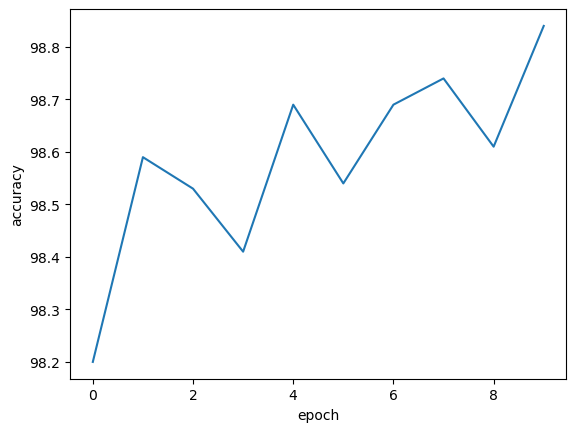

In [8]:
if __name__ == '__main__':
    epoch_list = []
    acc_list = []

    for epoch in range(10):
        train(epoch)
        acc = test()
        epoch_list.append(epoch)
        acc_list.append(acc)

    plt.plot(epoch_list,acc_list)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.savefig('./result.jpg')
    plt.show()
